Test on centerline loss

In [175]:
import sys
sys.path.append('..')

import numpy as np
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')
import torch
import cv2
from test_reconst_v2 import ConstructionBezier
# from test_loss_define_v2 import ContourChamferLoss, TipDistanceLoss, GenerateRefData
import torch.nn as nn
import matplotlib.pyplot as plt

In [176]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 10, 255, cv2.THRESH_BINARY)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

def read_gt_params(cc_specs_path):
    """
    The order of gt: [p_start, p_end, c1, c2]
    """
    
    para_gt_np = np.load(cc_specs_path)
    matrix = np.squeeze(para_gt_np)
    c1 = matrix[2]
    c2 = matrix[3]
    p_start = matrix[0]
    p_end = matrix[1]
    p_mid = 3/4 * (c1 + p_end/3)
    p1 = 2*p_mid - 0.5*p_start - 0.5*p_end
    result_vector = np.concatenate((p1, p_end))
    return result_vector 

In [177]:
if torch.cuda.is_available():
    gpu_or_cpu = torch.device("cuda:0") 
    torch.cuda.set_device(gpu_or_cpu)
else:
    gpu_or_cpu = torch.device("cpu")

case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/gt_dataset3/gt_6_0.0006_-0.0010_0.2_0.01'
# case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_gt_4'
img_save_path = case_naming + '.png'
cc_specs_path = case_naming + '.npy'

para_gt_np = read_gt_params(cc_specs_path)
print(para_gt_np)

p_start = torch.tensor([2e-2, 2e-3, 1e-8]).to(gpu_or_cpu) # 0 here will cause NaN in draw2DCylinderImage, pTip
# para_init = np.array([0.13, 0.12, 0.9, 0.06, 0.033, 0.5],
#                     dtype=np.float32)
para_init = nn.Parameter(torch.from_numpy(para_gt_np).to(gpu_or_cpu),
                                      requires_grad=True)


img_ref_binary = process_image(img_save_path)

image_ref = torch.from_numpy(img_ref_binary.astype(np.float32)).to(gpu_or_cpu)
print(image_ref.shape)

save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/test_imgs/rendered_imgs_old/initial_frame_9.png'

[ 2.15634587e-02 -6.05764476e-04  5.16317712e-01  1.65068886e-01
 -2.39781477e-01  9.49010349e-01]
torch.Size([480, 640])


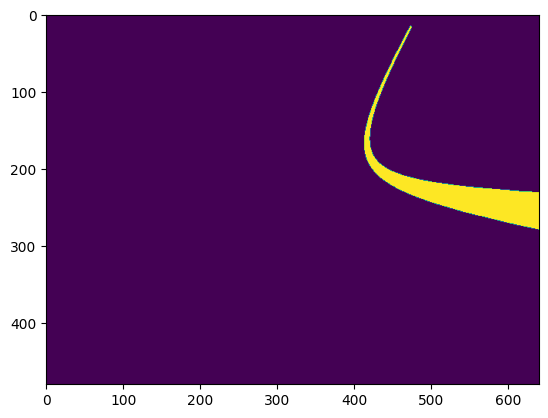

In [178]:
plt.imshow(img_ref_binary)

In [179]:
build_bezier = ConstructionBezier()
build_bezier.to(gpu_or_cpu)
build_bezier.loadRawImage(img_save_path)
build_bezier.getBezierCurveCylinder(p_start, para_init)
build_bezier.getCylinderMeshProjImg()
build_bezier.getBezierProjImg()
# build_bezier.draw2DCylinderImage(image_ref, save_img_path)

In [180]:
bezier_proj_img = build_bezier.bezier_proj_img.detach().numpy()
bezier_proj_centerline_img = build_bezier.bezier_proj_centerline_img.detach().numpy()
print("Shape of bezier_proj_img", bezier_proj_img.shape)
print("Shape of bezier_proj_centerline_img", bezier_proj_centerline_img.shape)
img_render_point_cloud = bezier_proj_img.reshape(bezier_proj_img.shape[0] * bezier_proj_img.shape[1], 2)
print("Shape of img_render_point_cloud", img_render_point_cloud.shape)

Shape of bezier_proj_img (30, 50, 2)
Shape of bezier_proj_centerline_img (30, 2)
Shape of img_render_point_cloud (1500, 2)


Projected tip (473, 16)


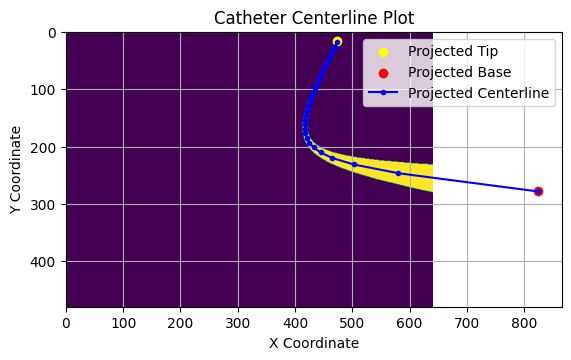

In [181]:
projected_base = (int(bezier_proj_centerline_img[1, 0]), int(bezier_proj_centerline_img[1, 1]))
projected_tip = (int(bezier_proj_centerline_img[-1, 0]), int(bezier_proj_centerline_img[-1, 1]))
print("Projected tip", projected_tip)

x = bezier_proj_centerline_img[1:, 0]
y = bezier_proj_centerline_img[1:, 1]

# 绘制这些坐标点
# plt.figure(figsize=(8, 6))
plt.imshow(img_ref_binary)

plt.scatter(projected_tip[0], projected_tip[1], color='yellow', label='Projected Tip')  
plt.scatter(projected_base[0], projected_base[1], color='red', label='Projected Base')

plt.plot(x, y, marker='o', linestyle='-', color='b', label='Projected Centerline', markersize=3)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Catheter Centerline Plot')
plt.legend()
plt.grid(True)
plt.show()

In [182]:
import skimage.morphology as skimage_morphology

class GenerateRefData(): 
    '''
    Class used to generate reference data for the catheter reconstruction model.
    '''
    def __init__(self, img_ref):
        self.img_ref = img_ref

    def get_raw_centerline(self):
        '''
        Method to get the raw centerline of the catheter from the reference image.
        '''

        # convert to numpy array
        img_ref = self.img_ref.cpu().detach().numpy().copy()

        img_height = img_ref.shape[0]
        img_width = img_ref.shape[1]

        # perform skeletonization, need to extend the boundary of the image because of the way the skeletonization algorithm works (it looks at the 8 neighbors of each pixel)
        extend_dim = int(60)
        img_thresh_extend = np.zeros((img_height, img_width + extend_dim))
        img_thresh_extend[0:img_height, 0:img_width] = img_ref / 1.0

        # get the left boundary of the image
        left_boundarylineA_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 1]))
        left_boundarylineB_id = np.squeeze(np.argwhere(img_thresh_extend[:, img_width - 10]))

        # get the center of the left boundary
        extend_vec_pt1_center = np.array([img_width, (left_boundarylineA_id[0] + left_boundarylineA_id[-1]) / 2])
        extend_vec_pt2_center = np.array(
            [img_width - 5, (left_boundarylineB_id[0] + left_boundarylineB_id[-1]) / 2])
        exten_vec = extend_vec_pt2_center - extend_vec_pt1_center

        # avoid dividing by zero
        if exten_vec[1] == 0:
            exten_vec[1] += 0.00000001

        # get the slope and intercept of the line
        k_extend = exten_vec[0] / exten_vec[1]
        b_extend_up = img_width - k_extend * left_boundarylineA_id[0]
        b_extend_dw = img_width - k_extend * left_boundarylineA_id[-1]

        # extend the ROI to the right, so that the skeletonization algorithm could be able to get the centerline
        # then it could be able to get the intersection point with boundary
        extend_ROI = np.array([
            np.array([img_width, left_boundarylineA_id[0]]),
            np.array([img_width, left_boundarylineA_id[-1]]),
            np.array([img_width + extend_dim,
                      int(((img_width + extend_dim) - b_extend_dw) / k_extend)]),
            np.array([img_width + extend_dim,
                      int(((img_width + extend_dim) - b_extend_up) / k_extend)])
        ])

        # fill the extended ROI with 1
        img_thresh_extend = cv2.fillPoly(img_thresh_extend, [extend_ROI], 1)

        # skeletonize the image
        skeleton = skimage_morphology.skeletonize(img_thresh_extend)

        # get the centerline of the image
        img_raw_skeleton = np.argwhere(skeleton[:, 0:img_width] == 1)

        self.img_raw_skeleton = torch.as_tensor(img_raw_skeleton).float()

        return self.img_raw_skeleton
        
    def get_raw_contour(self): 
        '''
        Method to compute the raw contour of the catheter from the reference image.
        '''

        # Convert reference image to numpy array of type np.uint8 to be able to use OpenCV
        img_ref = self.img_ref.cpu().detach().numpy().copy().astype(np.uint8)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(img_ref, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Extract the largest contour (assuming it's the tube)
        largest_contour = max(contours, key=cv2.contourArea)

        # Extract coordinates of contour pixels
        ref_catheter_contour_coordinates = largest_contour.squeeze()

        # Convert coordinates to PyTorch tensor
        self.ref_catheter_contour_point_cloud = torch.tensor(ref_catheter_contour_coordinates, dtype=torch.float)

        return self.ref_catheter_contour_point_cloud

In [183]:
class CenterlineLoss(nn.Module): 
    '''
    Class to define the contour chamfer loss function between two images.
    '''
    def __init__(self, device): 
        super(CenterlineLoss, self).__init__()
        self.device = device

    def forward(self, bezier_proj_centerline_img, ref_catheter_centerline): 
        '''

        '''
        ref_catheter_centerline = ref_catheter_centerline.flip(1)
        bezier_proj_centerline_img = bezier_proj_centerline_img.flip(0)
        
        mask_proj = (bezier_proj_centerline_img[:, 0] >= 0) & (bezier_proj_centerline_img[:, 0] <= 640) & \
            (bezier_proj_centerline_img[:, 1] >= 0) & (bezier_proj_centerline_img[:, 1] <= 480)
        bezier_proj_centerline_img = bezier_proj_centerline_img[mask_proj]
        
        # downsample
        target_num_points = bezier_proj_centerline_img.shape[0]
        
        indices_ref = torch.linspace(0, ref_catheter_centerline.shape[0] - 1, target_num_points).long()
        ref_catheter_centerline = ref_catheter_centerline[indices_ref]
        
        distances = torch.sqrt(torch.sum((bezier_proj_centerline_img - ref_catheter_centerline) ** 2, dim=1))

        average_distance = torch.mean(distances)

        return average_distance
    

In [184]:
image_ref = torch.from_numpy(img_ref_binary.astype(np.float32))
generate_ref_data = GenerateRefData(image_ref)
ref_catheter_contour = generate_ref_data.get_raw_contour()
ref_catheter_centerline = generate_ref_data.get_raw_centerline()

In [185]:
img_raw_skeleton = ref_catheter_centerline.flip(1)
ref_skeleton_tip_point = img_raw_skeleton[0, :]
ref_skeleton_base_point = img_raw_skeleton[-1, :]

tip_coords = ref_skeleton_tip_point.numpy().astype(int)
base_coords = ref_skeleton_base_point.numpy().astype(int)

img_raw_skeleton_np = img_raw_skeleton.numpy().astype(int)
print(img_raw_skeleton_np.shape)

num_points = bezier_proj_centerline_img.shape[0]
n = img_raw_skeleton_np.shape[0]
step = n // num_points
indices = np.arange(0, n, step)
img_raw_skeleton_np = img_raw_skeleton_np[indices]


(392, 2)


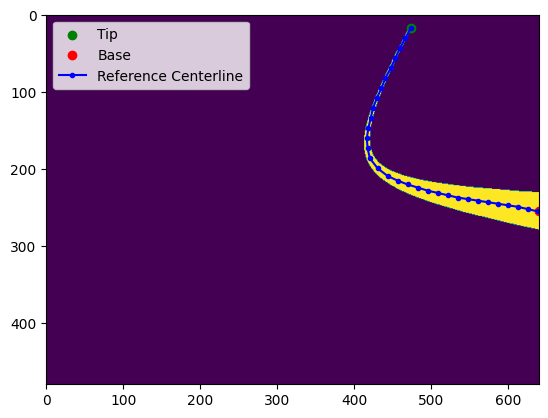

In [186]:
x = img_raw_skeleton_np[:, 0]
y = img_raw_skeleton_np[:, 1]

# Display the image using matplotlib
plt.imshow(img_ref_binary)
plt.scatter(tip_coords[0], tip_coords[1], color='green', label='Tip')  
plt.scatter(base_coords[0], base_coords[1], color='red', label='Base')
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Reference Centerline', markersize=3)
plt.legend()
plt.show()

In [187]:
centerline_loss = CenterlineLoss(device=gpu_or_cpu)
loss_centerline = centerline_loss(build_bezier.bezier_proj_centerline_img.to(gpu_or_cpu), ref_catheter_centerline.to(gpu_or_cpu))
print("Centerline Loss", loss_centerline)

Centerline Loss tensor(81.8962, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [188]:


# contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
# loss_contour = contour_chamfer_loss(build_bezier.bezier_proj_img.to(gpu_or_cpu), ref_catheter_contour.to(gpu_or_cpu))
# tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
# loss_tip_distance, _ = tip_distance_loss(build_bezier.bezier_proj_centerline_img.to(gpu_or_cpu), ref_catheter_centerline.to(gpu_or_cpu))


In [189]:
# print("Loss contour", loss_contour)
# print("Loss tip distance", loss_tip_distance)